# Assignment2
## CS-5891-01 Special Topics Deep Learning
## Ronald Picard

In this notebook we will walk through the design, training, and testing of a neural network with one nueron. This nueral network will be used for logistic regression, which is an archaic name for binary classification.

The binary classification will be performed on images of handwritten numerical digits. More specifically, the last numerical digit of my student ID. This digit happens to be 9. Therefore, the goal of our neural network will be to output a the value of 1 when the handwritten numerical digit image input is a 9, and 0 in all other cases.

The data set we will be using is the MNIST data set. This is a very popular data set amoung the machine learning community. The data set contains 60,000 images, and each image contains a handwritten numerical digit. Each of the images have been provided with a truth label that corresponds to the handwritten digit within the image from the set {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}. 

For our case, we only care about when the image is 9. Therefore we will need to re-label the truth labels so that all truth labels with the value of 9 are given to the value of 1, and all other truth labels are given the value of 0. 

To start we need to import some needed classes.

In [1]:
import os
import numpy as np
import struct
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as pyplot
import csv
import time

First, we must change our path string to the path of our data file containing the features. (Please note that you must change this string to point to the directory with the data file on your machine data file on your machine.) 

Second, we much change the string name of the data files to the names of the MNIST data files. (Please note that you may NOT need to change these. Only change them if your MINST data files are named differently.)

In [2]:
## path
path = 'C:/Users/computer/OneDrive - Vanderbilt/Vanderbilt_Spring_2019/CS_5891_01_SpecialTopicsDeepLearning/Assignment2/'

#Train data
fname_train_images = os.path.join(path, 'train-images.idx3-ubyte')  # the training set image file path
fname_train_labels = os.path.join(path, 'train-labels.idx1-ubyte')  # the training set label file path

Next, we retrieve the data from the data files as follows. This imports the data into a feature tensor (3-D matrix) in which each index is a feature matrix corresponding to an image. The label data comes in the form of a vector where each index corresponds to the index of the feature matrix (image) of the feature tensor.  

In [3]:
# open the label file and load it to the "train_labels"
with open(fname_train_labels, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    labels = np.fromfile(flbl, dtype=np.uint8)

# open the image file and load it to the "train_images"
with open(fname_train_images, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    images = np.fromfile(fimg, dtype=np.uint8).reshape(len(labels), rows, cols)

print('The training set contains', len(images), 'images')  # print the how many images contained in the training set
print('The shape of the image is', images[0].shape)  # print the shape of the image

The training set contains 60000 images
The shape of the image is (28, 28)


Next, we need to perform both two steps; feature scaling and feature normalization. Feature scaling consists of converting the 28 X 28 image matrices into 784 X 1 feature vectors. In essence we will flatten the images out into vectors so that we can use an input a vector to our single neuron. Feature normalization is a process of normalizing the pixel data to between 0 <= x <= 1 (for logistic regression). Each pixel comes on a scale of 0 <= x <= 255. Since 255 is the maximum for every pixel we shall divide each pixel by that number (elementwise) in order to normalize each pixel to between 0 and 1 (inclusive).

One additional item we need to take care of is relabeling our label (truth) data so that we have a binary classification in which all 9s are converted to 1s and all other labels are converted to 0.

In [4]:
# feature scaling
matrix_side_length = len(images[0])
vector_size = matrix_side_length*matrix_side_length

scaled_images_feature_matrix = []
for image in images:
    reshaped_image = np.array(image).reshape((vector_size))
    scaled_images_feature_matrix.append(reshaped_image)

# convert to numpy array
scaled_images_feature_matrix = np.transpose(np.array(scaled_images_feature_matrix))
print(scaled_images_feature_matrix.shape) # scaled_images_feature_matrix is a matrix of 60000 X 784
#print(scaled_images_feature_matrix[0].shape)

# feature normilization
normilization_factor = 1/255
normalized_scaled_images_feature_matrix = np.multiply(normilization_factor, scaled_images_feature_matrix)
print(normalized_scaled_images_feature_matrix.shape)
#print(normalized_scaled_images_feature_matrix[0])

# re-label for binary classification
value_for_1 = 9
binary_labels = []
for label in labels:
    if(label == 9):
        binary_labels.append(1)
    else:
        binary_labels.append(0)

# convert to numpy array
binary_labels = np.array(binary_labels)
print(len(binary_labels)) # binary_labels is a row vector of 1 X 60000
#print(binary_labels[0])


(784, 60000)
(784, 60000)
60000


In order to test the efficacy of our nueral network, we need to split up the our label data into two data sets; a smaller and a larger one. The larger set will be the training data that we will use to train our nueral network on. The smaller set will be the testing data that we will used to test the accuracy of our nueral net. The MNIST data set contains 60,000 images. Therefore, we will use 50,000 images for our training data set, and 10,000 images for our testing data set. 

It is common practice to use a smaller subset of the total data set to debug and tune hyper-parameters before using the entire time-comsuming data set. This smaller subset is known as a validation set. Therefore, we will first use a validation data set of 600 images. 500 of these images will be used for as our training data set, and the other 100 of these images will be used for our test data set. This validation set step is not nessesary with our single-neuron network, but we will do it for completeness sake; however, after our network is working we won't waste time on tuning hyper-parameters with this validation set, because in this case our full data set will run quickly as well. 

Thus, we will begin by sifting out a validation set from our total data set.

In [5]:
# create a validation data set
size = vector_size

number_of_testing_images = 100
number_of_training_images = 500
number_of_validation_images = number_of_testing_images + number_of_training_images

validation_training_images = []
validation_training_labels = []
validation_testing_images = []
validation_testing_labels = []

for index in range(0, number_of_validation_images):
    if(index <= number_of_training_images - 1):
        validation_training_images.append(normalized_scaled_images_feature_matrix[:, index])        
        validation_training_labels.append(binary_labels[index])
    else:
        validation_testing_images.append(normalized_scaled_images_feature_matrix[:, index])        
        validation_testing_labels.append(binary_labels[index])
        
# covert to numpy array
validation_training_images = np.transpose(np.array(validation_training_images))
validation_training_labels = np.array(validation_training_labels)
validation_testing_images = np.transpose(np.array(validation_testing_images))
validation_testing_labels = np.array(validation_testing_labels)

# logger
print(validation_training_images.shape) # validation_training_images is a matrix of 784 X 500
print(validation_training_labels.shape) # validation_testing_labels is a row vector of 1 X 500
print(validation_testing_images.shape) # validation_training_images is a matrix of 784 X 100
print(validation_testing_labels.shape)  # validation_testing_labels is a row vector of 1 X 100

(784, 500)
(500,)
(784, 100)
(100,)


Now we move on to the training of our single-neuron neural network. 

Part 1 - Feed Forword:

For this neural network we will stick with a simple model of one nueral. This nueron will have an input of a matrix (784 X number_of_images) of vectorized images of 784 X 1, and will output a row vector of probabilities which we will convert into binary classifications of 0 or 1. (If P(x) >= 0.5 then we will convert it to a 1, otherwise we will convert to 0.) The model of the neuron will be a vecorized linear model Y = W^T * X + B, where W is a vector of parameter weights, X is the input matrix of vectorized images, and B is a row vector of bias's. (Note: in this case, b will be scalar that applied in a broadcasing manner to save on memory.) The output row vector of this linear model will be subject to an elementwise sigmoid activation function. The sigmoid activation function is A = sigma(Z) = 1/(1 - e^-Z), where Z = Y. The resultant row vector will then be used to calculate the cost function values in an elementwise manner. The cost function for this binary classification will be L(Y_Predicted, Y_Label) = -Y_Label * Log(A) - (1-Y_Predicted) * Log(1-A), where Y_Label is the True Label, Y_Predicted is the probability value predicted by the nueral network, and A is the activation function value. The resultant cost row vector will be added up and divided by the number of elements in order to calculate the average cost. 

Part 2 - Back Propogation:

The back propogation technique that we will use for training the nueral network, will be gradient descent. This involes utiling the gradient of the cost function to updated our model parameters. In order to calculate the gradient we will utilize the chain rule. The goal of back propogation is the adjust the parameter weights and bias's of our model to accurately perform binary classification. In general the chain rule can be used to find the gradient of these cost function (vecorzied rates of change) with respect to the model parameters. The following is the chain that we will utilize. Note that it is in the form of scalar cases, but we will utilized a vectorized verion.

dl(a, y)/dw = dl(a, y)/da * da/dz * dz/w 

dl(a, y)/db = dl(a, y)/da * da/dz * dz/b



The partial derivative of the cost function with respect to the activation function is found by the following:

dl(a, y)/da = -y/a + (1-y)/(1-a).



Due to the chain rule, the derivative of the cost function with respect to the linear model z (where z = y) is found by the following:

dl(a, y)/dz = dL(a, y)/da * da/dz.

The derivative of the sigmoid activation function is da/dz is found by the following:

da/dz = sigma(z) = sigma(z) * (1-sigma(z))

Therefore the derivative of the cost function with respect to the output of the linear model is found by the following:

dl(a, y)/da * da/dz = (-y/a + (1-y)/(1-a)) * (sigma(z) * (1-sigma(z))) = a-y. (For convienence we will say dz = a-y.)



Now we can extrapolate the chain rule to all the way to the paramters of the linear model.

dl(a, y)/dw = dl(a, y)/da * da/dz * dz/w = dL(a, y)/da * da/dz * x = dz * x = x * dz (we will change our notation to dw = x * dz for convienence)

dl(a, y)/db = dl(a, y)/da * da/dz * dz/b = dz * 1 = dz (we will change our notation to db = dz for convienence)



Now we can set up the vectorized version of our gradient, then take the average of dw and db.

dZ = A - Y^T, where A is a row vector of activation function output, and Y is the vector of truth labels.

dW = 1/m * (X * dZ^T), where X is our feature matrix of vectorized images, and dZ is a vector of the rate of change of our cost function with respect to the activation function, and m is the number of elements in the resultant vector.

dB = 1/m * sum(dZ), where dZ is the rate of change of our cost function with respect to the activation function.

Finally, we will multiple our gradient transposed parameter row vectors by our learning rate and then subtract this from our parameter vectors.

W:= W - alpha * dW^T

W:= B - alpha * dB^T

The first thing we have have to do is initialize our weights and bias's. The weights and bias's will initialized to 0.01. This was choosen pseudo-randomly.  

In [6]:
# initialize weights & bias
initial_value = .01
W = np.multiply(initial_value, np.ones(size))
b = initial_value # b will be added in a broadcasting manner

print(W.shape) # W is a vector with a size of 784

(784,)


Now we implement our gradient descent algorithm.

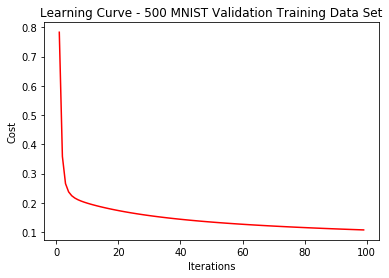

In [7]:
# gradient descent

# hyber-parameters
alpha = 0.1;
number_of_iterations = 100

# data arrays
cost_array = []
interation_array = []

# rename
X = validation_training_images
Y = validation_training_labels
m = size

# main loop
for interation in range(1, number_of_iterations):
    
    # forward propogation
    Z = np.dot(np.transpose(W), X) + b # Linear Model # Z is 1X500 # broadcasting is used
    A = 1/(1 + np.exp(-Z)) # sigmoid(Z) # A is 1X500 # broadcasting is used 
    term1 = np.multiply(-Y, np.log(A)) # -Y * log(A) # broadcasting is used 
    term2 = np.multiply((1 - Y), np.log(1 - A)) # (1-Y) * log(1-A) # broadcasting is used 
    L = term1 - term2 # loss function # l is 1X500
    cost = np.multiply(1/m, np.sum(L)) # cost # scalar
    
    # storage for plotting
    cost_array.append(cost)
    interation_array.append(interation)
    
    # backpropogation
    dZ = A - Y # dZ is 1X500
    dW = np.multiply(1/m, np.dot(X, np.transpose(dZ))) # dW is 784X1
    db = np.multiply(1/m, np.sum(dZ)) # db is a scalar
    
    # paramter updates
    W = W - np.multiply(alpha, dW)
    b = b - np.multiply(alpha, db)
    
    
# plot learning curve
pyplot.figure()
pyplot.plot(interation_array, cost_array, 'red')
pyplot.title('Learning Curve - 500 MNIST Validation Training Data Set')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

As shown, our validation set worked, so now we can move on to the full data set.

First, we need to split up our full data set into testing and training data. We will use 50,000 images as the training data set and 10,000 images as the testing data set. 

In [14]:
# separate the data set
nbr_of_testing_images = 10000
nbr_of_training_images = 50000
nbr_of_images = nbr_of_testing_images + nbr_of_training_images

training_images = []
training_labels = []
testing_images = []
testing_labels = []

for index in range(0, nbr_of_images):
    if(index <= nbr_of_training_images - 1):
        training_images.append(normalized_scaled_images_feature_matrix[:, index])        
        training_labels.append(binary_labels[index])
    else:
        testing_images.append(normalized_scaled_images_feature_matrix[:, index])        
        testing_labels.append(binary_labels[index])
        
# covert to numpy array
training_images = np.transpose(np.array(training_images))
training_labels = np.array(training_labels)
testing_images = np.transpose(np.array(testing_images))
testing_labels = np.array(testing_labels)

# logger
print(training_images.shape) # training_images is a matrix of 784 X 50000
print(training_labels.shape) # testing_labels is a row vector of 1 X 50000
print(testing_images.shape) # training_images is a matrix of 784 X 10000
print(testing_labels.shape)  # testing_labels is a row vector of 1 X 10000

(784, 50000)
(50000,)
(784, 10000)
(10000,)


Now we must reset out weights and bias's.

In [15]:
# initialize weights & bias
initial_value = .1
W = np.multiply(initial_value, np.ones(size))
b = initial_value # b will be added in a broadcasting manner

print(W.shape) # W is a vector with a size of 784

(784,)


Now we re-run gradient decent on the full data set.

We will also collected data on the accuracy of our network as a function of training iterations. To do this we will need to find the number of inaccuracate binary classifications (false positives & false negatives). This will be acommplished used our test data set. We will send our test data set through the network and compare the results with the true labels of the test data set. 

Final Cost: 7.367329980635536
Final Percent Accuracy: 96.4


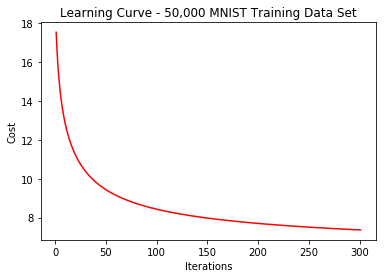

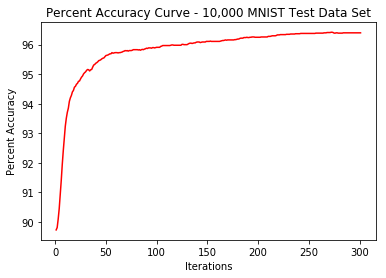

In [17]:
# gradient descent

# hyber-parameters
alpha = 0.01;
number_of_iterations =300

# data arrays
cost_array = []
interation_array = []
accuracy_array = []

# rename
X = training_images
Y = training_labels
m = size

# main loop
for interation in range(1, number_of_iterations):
    
    # forward propogation training data set
    Z = np.dot(np.transpose(W), X) + b # Linear Model # Z is 1X50000 # broadcasting is used
    A = 1/(1 + np.exp(-Z)) # sigmoid(Z) # A is 1X50000 # broadcasting is used 
    term1 = np.multiply(-Y, np.log(A)) # -Y * log(A) # broadcasting is used 
    term2 = np.multiply((1 - Y), np.log(1 - A)) # (1-Y) * log(1-A) # broadcasting is used 
    L = term1 - term2 # loss function # l is 1X50000
    cost = np.multiply(1/m, np.sum(L)) # cost # scalar    
    
        
    # forward propogation test data set
    Z_test = np.dot(np.transpose(W), testing_images) + b # Linear Model # Z is 1X50000 # broadcasting is used
    A_test = 1/(1 + np.exp(-Z_test)) # sigmoid(Z) # A is 1X50000 # broadcasting is used 
    
    # accuracy
    prediction_labels = np.where(A_test >= 0.5, 1, 0) # if greater than ore equal to 0.5 use 1, else 0
    accuracy = np.sum(np.absolute(testing_labels - prediction_labels)) # Sum of false positives and false negatives # accuracy is scalar   
    percent_inaccurate = np.multiply(100/len(testing_labels), accuracy)
    percent_accurate = 100 - percent_inaccurate
    
    # storage for plotting
    cost_array.append(cost)
    accuracy_array.append(percent_accurate)
    interation_array.append(interation)
    
    # backpropogation
    dZ = A - Y # dZ is 1X500
    dW = np.multiply(1/m, np.dot(X, np.transpose(dZ))) # dW is 784X1
    db = np.multiply(1/m, np.sum(dZ)) # db is a scalar
    
    # paramter updates
    W = W - np.multiply(alpha, dW)
    b = b - np.multiply(alpha, db)

# forward propogation training data set
Z = np.dot(np.transpose(W), X) + b # Linear Model # Z is 1X50000 # broadcasting is used
A = 1/(1 + np.exp(-Z)) # sigmoid(Z) # A is 1X50000 # broadcasting is used 
term1 = np.multiply(-Y, np.log(A)) # -Y * log(A) # broadcasting is used 
term2 = np.multiply((1 - Y), np.log(1 - A)) # (1-Y) * log(1-A) # broadcasting is used 
L = term1 - term2 # loss function # l is 1X50000
cost = np.multiply(1/m, np.sum(L)) # cost # scalar   

# forward propogation test data set
Z_test = np.dot(np.transpose(W), testing_images) + b # Linear Model # Z is 1X50000 # broadcasting is used
A_test = 1/(1 + np.exp(-Z_test)) # sigmoid(Z) # A is 1X50000 # broadcasting is used 

# final accuracy
prediction_labels = np.where(A_test >= 0.5, 1, 0) # if greater than ore equal to 0.5 use 1, else 0
accuracy = np.sum(np.absolute(testing_labels - prediction_labels)) # Sum of false positives and false negatives # accuracy is scalar   
percent_inaccurate = np.multiply(100/len(testing_labels), accuracy)
percent_accurate = 100 - percent_inaccurate

# storage for plotting
cost_array.append(cost)
accuracy_array.append(percent_accurate)
interation_array.append(number_of_iterations + 1)
    
print('Final Cost: ' + str(cost))
print('Final Percent Accuracy: ' + str(percent_accurate))

# plot learning curve
pyplot.figure()
pyplot.plot(interation_array, cost_array, 'red')
pyplot.title('Learning Curve - 50,000 MNIST Training Data Set')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array, 'red')
pyplot.title('Percent Accuracy Curve - 10,000 MNIST Test Data Set')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

As illustrated, the learning curve flattens out (pesudo-plateau's) at apprximately 8.51270 after 100 training iterations, but adjusts very little after just a few iterations. The percent accuracy initially dramatically increases, then decreases a little bit, then steadly increases assomototically to approximately 95.88% after 100 training iteration. This is reasonable considering that we only have one neuron in our network.

Now we will run through some examples classifications in the network. We will find one true positive, one true negative, one false positive, and one false negative.

True Negative Found: True Label: 0 Predicted: 0, @ Test Data Index: 0, Size; (1, 28, 28)


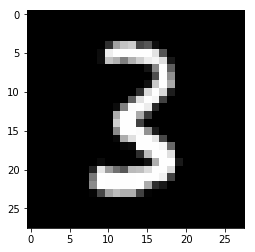

False Negative Found: True Label: 1 Predicted: 0, @ Test Data Index: 3, Size; (1, 28, 28)


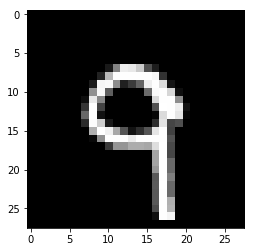

False Positive Found: True Label: 0 Predicted: 1, @ Test Data Index: 89, Size; (1, 28, 28)


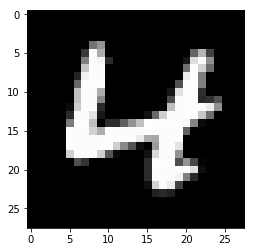

True Postitive Found: True Label: 1 Predicted: 1, @ Test Data Index: 304, Size; (1, 28, 28)


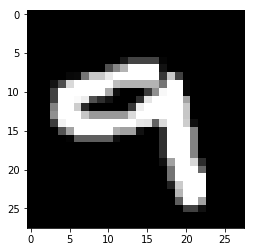

In [11]:
true_positive_found = 0
true_negative_found = 0
false_postitive_found = 0
false_negative_found = 0

true_positive_example = []
true_negative_example = []
false_postitive_example = []
false_negative_example = []

for index in range(0, len(testing_labels)-1):
    true_label = testing_labels[index]
    predicted_label = prediction_labels[index]
    #print('True Label: ' + str(true_label))
    #print('Predicted Label: ' + str(predicted_label))
    if(false_negative_found and false_postitive_found and true_positive_found and true_negative_found):
        break
    elif(not false_negative_found and true_label == 1 and predicted_label == 0):
        false_negative_found = 1
        false_negative_example.append(np.array(images[nbr_of_training_images + index]))
        print('False Negative Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(false_negative_example).shape))
        pyplot.imshow(false_negative_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not false_postitive_found and true_label == 0 and predicted_label == 1):
        false_postitive_found = 1
        false_postitive_example.append(np.array(images[nbr_of_training_images + index]))
        print('False Positive Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(false_postitive_example).shape))
        pyplot.imshow(false_postitive_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not true_positive_found and true_label == 1 and predicted_label == 1):
        true_positive_found = 1
        true_positive_example.append(np.array(images[nbr_of_training_images + index]))
        print('True Postitive Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(true_positive_example).shape))
        pyplot.imshow(true_positive_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not true_negative_example and true_label == 0 and predicted_label == 0):
        true_negative_found = 1
        true_negative_example.append(np.array(images[nbr_of_training_images + index]))
        print('True Negative Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(true_negative_example).shape))
        pyplot.imshow(true_negative_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()         

As illustrated above, we have found one of each possible case; True Negative, True Postitive, False Positive, False Negative. Recall that our truth values are 1 for images with a 9, and 0 in all other cases.

The true negative image shown above is of a 3. Since 3 is not 9, the true label for the image is 0, and the neural network correctly classified it as such.

The true positive image shown above is of a 9. The true label for 9 is 1, and the neuarl network correctly classified it as such.

The false positive image shown above is of a 7. Since 7 is not 9, the true label for the image is 0. However, the nueral network incorrectly classified this image as a 9, thus predicted a 1. This inaccurate classification is relatively understandable since we have a simple single-neuron neural network and the the 7 in this image is bent so that it's features are more similar to a 9 than to a written 7. 

The false negative image shown about is an image of a 9. The true label for a 9 is 1. However, our neural network inccorectly classified this image as 'not a 9'. It is not easily possible to know exactly why this occured but our intuition can tell us a couple things. First, we are using a simple single-neuron neural network, so it is generally understandable that it will not be 100% accurate. In fact no nueral network is truly 100% accurate; at least philosophically. Second, we can see in this image that the 9 is round and could potentially be mistaken for a 3 or 0. 

Now that we have a good model we would like to investigate the impact of the accuracy of our network to lowing the training data size. In order to do some a comparision with our results above we will use 10,000 images for training now, but still use 10,000 images for testing. This will reveal what our results are when we have a much smaller training data set. 

Final Cost: 2.272081920095334
Final Percent Accuracy: 92.72


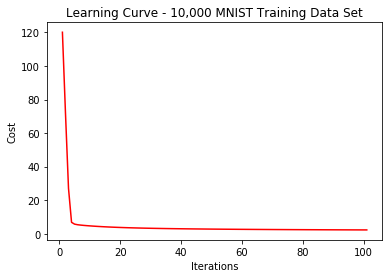

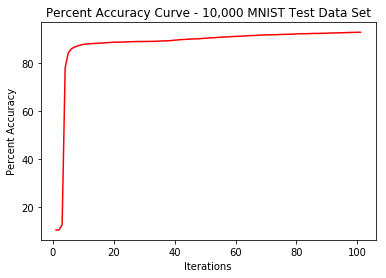

In [12]:
# separate the data set
nbr_of_testing_images = 10000
nbr_of_training_images = 10000
nbr_of_images = nbr_of_testing_images + nbr_of_training_images

training_images = []
training_labels = []
testing_images = []
testing_labels = []

for index in range(0, nbr_of_images):
    if(index <= nbr_of_training_images - 1):
        training_images.append(normalized_scaled_images_feature_matrix[:, index])        
        training_labels.append(binary_labels[index])
    else:
        testing_images.append(normalized_scaled_images_feature_matrix[:, index])        
        testing_labels.append(binary_labels[index])
        
# covert to numpy array
training_images = np.transpose(np.array(training_images))
training_labels = np.array(training_labels)
testing_images = np.transpose(np.array(testing_images))
testing_labels = np.array(testing_labels)

# logger
#print(training_images.shape) # training_images is a matrix of 784 X 50000
#print(training_labels.shape) # testing_labels is a row vector of 1 X 50000
#print(testing_images.shape) # training_images is a matrix of 784 X 10000
#print(testing_labels.shape)  # testing_labels is a row vector of 1 X 10000

# initialize weights & bias
initial_value = .1
W = np.multiply(initial_value, np.ones(size))
b = initial_value # b will be added in a broadcasting manner

#print(W.shape) # W is a vector with a size of 784

# gradient descent

# hyber-parameters
alpha = 0.01;
number_of_iterations = 100

# data arrays
cost_array = []
interation_array = []
accuracy_array = []

# rename
X = training_images
Y = training_labels
m = size

# main loop
for interation in range(1, number_of_iterations):
    
    # forward propogation training data set
    Z = np.dot(np.transpose(W), X) + b # Linear Model # Z is 1X50000 # broadcasting is used
    A = 1/(1 + np.exp(-Z)) # sigmoid(Z) # A is 1X50000 # broadcasting is used 
    term1 = np.multiply(-Y, np.log(A)) # -Y * log(A) # broadcasting is used 
    term2 = np.multiply((1 - Y), np.log(1 - A)) # (1-Y) * log(1-A) # broadcasting is used 
    L = term1 - term2 # loss function # l is 1X50000
    cost = np.multiply(1/m, np.sum(L)) # cost # scalar    
    
    # forward propogation test data set
    Z_test = np.dot(np.transpose(W), testing_images) + b # Linear Model # Z is 1X50000 # broadcasting is used
    A_test = 1/(1 + np.exp(-Z_test)) # sigmoid(Z) # A is 1X50000 # broadcasting is used 
    
    # accuracy
    prediction_labels = np.where(A_test >= 0.5, 1, 0) # if greater than ore equal to 0.5 use 1, else 0
    accuracy = np.sum(np.absolute(testing_labels - prediction_labels)) # Sum of false positives and false negatives # accuracy is scalar   
    percent_inaccurate = np.multiply(100/len(testing_labels), accuracy)
    percent_accurate = 100 - percent_inaccurate
    
    # storage for plotting
    cost_array.append(cost)
    accuracy_array.append(percent_accurate)
    interation_array.append(interation)
    
    # backpropogation
    dZ = A - Y # dZ is 1X500
    dW = np.multiply(1/m, np.dot(X, np.transpose(dZ))) # dW is 784X1
    db = np.multiply(1/m, np.sum(dZ)) # db is a scalar
    
    # paramter updates
    W = W - np.multiply(alpha, dW)
    b = b - np.multiply(alpha, db)

# forward propogation training data set
Z = np.dot(np.transpose(W), X) + b # Linear Model # Z is 1X50000 # broadcasting is used
A = 1/(1 + np.exp(-Z)) # sigmoid(Z) # A is 1X50000 # broadcasting is used 
term1 = np.multiply(-Y, np.log(A)) # -Y * log(A) # broadcasting is used 
term2 = np.multiply((1 - Y), np.log(1 - A)) # (1-Y) * log(1-A) # broadcasting is used 
L = term1 - term2 # loss function # l is 1X50000
cost = np.multiply(1/m, np.sum(L)) # cost # scalar   

# forward propogation test data set
Z_test = np.dot(np.transpose(W), testing_images) + b # Linear Model # Z is 1X50000 # broadcasting is used
A_test = 1/(1 + np.exp(-Z_test)) # sigmoid(Z) # A is 1X50000 # broadcasting is used 

# final accuracy
prediction_labels = np.where(A_test >= 0.5, 1, 0) # if greater than ore equal to 0.5 use 1, else 0
accuracy = np.sum(np.absolute(testing_labels - prediction_labels)) # Sum of false positives and false negatives # accuracy is scalar   
percent_inaccurate = np.multiply(100/len(testing_labels), accuracy)
percent_accurate = 100 - percent_inaccurate

# storage for plotting
cost_array.append(cost)
accuracy_array.append(percent_accurate)
interation_array.append(number_of_iterations + 1)
    
print('Final Cost: ' + str(cost))
print('Final Percent Accuracy: ' + str(percent_accurate))

# plot learning curve
pyplot.figure()
pyplot.plot(interation_array, cost_array, 'red')
pyplot.title('Learning Curve - 10,000 MNIST Training Data Set')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array, 'red')
pyplot.title('Percent Accuracy Curve - 10,000 MNIST Test Data Set')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

The results reveal what is intuitively expected. The percent accuracy of the network levels-out at around 92.72 percent after 100 iterations, which is less than the percentage we achieved with a larger training data set. This empiracally leads us to conclude that the more training data we have, the higher accuracy we can achieve with our network. 

One last thing we wish to investigate is how the learning rate impacts our results. In order to test this we will decrease our learning rate to a value of 0.00001. This is a very low value, but we are doing this for testing purposes. We will adjust our training data set back to 50,000 images for a direct comparison to the good result we had earlier.

Final Cost: 481.390470076452
Final Percent Accuracy: 9.61


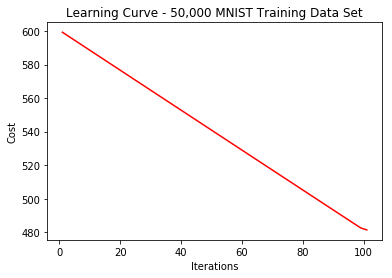

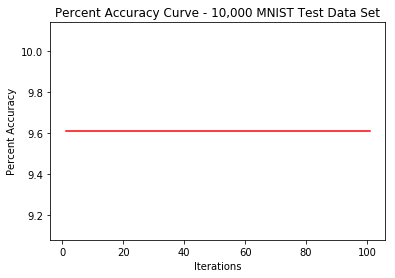

In [13]:
# separate the data set
nbr_of_testing_images = 10000
nbr_of_training_images = 50000
nbr_of_images = nbr_of_testing_images + nbr_of_training_images

training_images = []
training_labels = []
testing_images = []
testing_labels = []

for index in range(0, nbr_of_images):
    if(index <= nbr_of_training_images - 1):
        training_images.append(normalized_scaled_images_feature_matrix[:, index])        
        training_labels.append(binary_labels[index])
    else:
        testing_images.append(normalized_scaled_images_feature_matrix[:, index])        
        testing_labels.append(binary_labels[index])
        
# covert to numpy array
training_images = np.transpose(np.array(training_images))
training_labels = np.array(training_labels)
testing_images = np.transpose(np.array(testing_images))
testing_labels = np.array(testing_labels)

# logger
#print(training_images.shape) # training_images is a matrix of 784 X 50000
#print(training_labels.shape) # testing_labels is a row vector of 1 X 50000
#print(testing_images.shape) # training_images is a matrix of 784 X 10000
#print(testing_labels.shape)  # testing_labels is a row vector of 1 X 10000

# initialize weights & bias
initial_value = .1
W = np.multiply(initial_value, np.ones(size))
b = initial_value # b will be added in a broadcasting manner

#print(W.shape) # W is a vector with a size of 784

# gradient descent

# hyber-parameters
alpha = 0.00001;
number_of_iterations = 100

# data arrays
cost_array = []
interation_array = []
accuracy_array = []

# rename
X = training_images
Y = training_labels
m = size

# main loop
for interation in range(1, number_of_iterations):
    
    # forward propogation training data set
    Z = np.dot(np.transpose(W), X) + b # Linear Model # Z is 1X50000 # broadcasting is used
    A = 1/(1 + np.exp(-Z)) # sigmoid(Z) # A is 1X50000 # broadcasting is used 
    term1 = np.multiply(-Y, np.log(A)) # -Y * log(A) # broadcasting is used 
    term2 = np.multiply((1 - Y), np.log(1 - A)) # (1-Y) * log(1-A) # broadcasting is used 
    L = term1 - term2 # loss function # l is 1X50000
    cost = np.multiply(1/m, np.sum(L)) # cost # scalar    
    
    # forward propogation test data set
    Z_test = np.dot(np.transpose(W), testing_images) + b # Linear Model # Z is 1X50000 # broadcasting is used
    A_test = 1/(1 + np.exp(-Z_test)) # sigmoid(Z) # A is 1X50000 # broadcasting is used 
    
    # accuracy
    prediction_labels = np.where(A_test >= 0.5, 1, 0) # if greater than ore equal to 0.5 use 1, else 0
    accuracy = np.sum(np.absolute(testing_labels - prediction_labels)) # Sum of false positives and false negatives # accuracy is scalar   
    percent_inaccurate = np.multiply(100/len(testing_labels), accuracy)
    percent_accurate = 100 - percent_inaccurate
    
    # storage for plotting
    cost_array.append(cost)
    accuracy_array.append(percent_accurate)
    interation_array.append(interation)
    
    # backpropogation
    dZ = A - Y # dZ is 1X500
    dW = np.multiply(1/m, np.dot(X, np.transpose(dZ))) # dW is 784X1
    db = np.multiply(1/m, np.sum(dZ)) # db is a scalar
    
    # paramter updates
    W = W - np.multiply(alpha, dW)
    b = b - np.multiply(alpha, db)

# forward propogation training data set
Z = np.dot(np.transpose(W), X) + b # Linear Model # Z is 1X50000 # broadcasting is used
A = 1/(1 + np.exp(-Z)) # sigmoid(Z) # A is 1X50000 # broadcasting is used 
term1 = np.multiply(-Y, np.log(A)) # -Y * log(A) # broadcasting is used 
term2 = np.multiply((1 - Y), np.log(1 - A)) # (1-Y) * log(1-A) # broadcasting is used 
L = term1 - term2 # loss function # l is 1X50000
cost = np.multiply(1/m, np.sum(L)) # cost # scalar   

# forward propogation test data set
Z_test = np.dot(np.transpose(W), testing_images) + b # Linear Model # Z is 1X50000 # broadcasting is used
A_test = 1/(1 + np.exp(-Z_test)) # sigmoid(Z) # A is 1X50000 # broadcasting is used 

# final accuracy
prediction_labels = np.where(A_test >= 0.5, 1, 0) # if greater than ore equal to 0.5 use 1, else 0
accuracy = np.sum(np.absolute(testing_labels - prediction_labels)) # Sum of false positives and false negatives # accuracy is scalar   
percent_inaccurate = np.multiply(100/len(testing_labels), accuracy)
percent_accurate = 100 - percent_inaccurate

# storage for plotting
cost_array.append(cost)
accuracy_array.append(percent_accurate)
interation_array.append(number_of_iterations + 1)
    
print('Final Cost: ' + str(cost))
print('Final Percent Accuracy: ' + str(percent_accurate))

# plot learning curve
pyplot.figure()
pyplot.plot(interation_array, cost_array, 'red')
pyplot.title('Learning Curve - 50,000 MNIST Training Data Set')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array, 'red')
pyplot.title('Percent Accuracy Curve - 10,000 MNIST Test Data Set')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

The results line up with what we would intuitively expect. First, the cost does decrease but in 100 iterations it still hasn't gotten below approximately 481. This is because our low learning rate causes our parameters values to be updated at a very slow rate; therefore, the values cannot converge within 100 iterations. Second, we see the same issue being present in our accuracy. The final accuracy is about 9.61 percent; which is extremely low. This again points to the fact that with such a small learning the rate the paramter values are not able to converge within 100 iterations. 

As we can see from these examples, the single neuron neural network is not perfect, but even with this simple model we can achieve decently accurate results if we set our learning rate appropriately and have large enough of a training data set.

This concludes the assignment.